In [1]:
#### check data is correct(multi layer depth map), geometry valid, and visualze the joint (15 joints setting)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
test_3d_gt_rel_std = np.load('test/test_3d_gt_rel_std.npy')
test_3d_gt_rel_mean = np.load('test/test_3d_gt_rel_mean.npy')
gt_3d_train_rel = np.load('train/gt_3d_train_rel.npy')
train_3d_gt_rel_std = np.load('train/train_3d_gt_rel_std.npy')
train_3d_gt_rel_mean = np.load('train/train_3d_gt_rel_mean.npy')
test_2d_gt_std = np.load('test/test_2d_gt_std.npy')
test_2d_gt_mean = np.load('test/test_2d_gt_mean.npy')
train_2d_gt_std = np.load('train/train_2d_gt_std.npy')
train_2d_gt_mean = np.load('train/train_2d_gt_mean.npy')
gt_2d_test = np.load('test/gt_2d_test.npy')
gt_2d_train = np.load('train/gt_2d_train.npy')
J_test_gt_mdp_enc2_15 = np.load('test/J_test_gt_mdp_enc2_15.npy')
J_train_gt_mdp_enc2_15 = np.load('train/J_train_gt_mdp_enc2_15.npy')
J_test_gt_mdp_15 = np.load('test/J_test_gt_mdp_15.npy')
J_train_gt_mdp_15 = np.load('train/J_train_gt_mdp_15.npy')
test_gt_mdp_15 = np.load('test/test_gt_mdp_15.npy')
train_gt_mdp_15 = np.load('train/train_gt_mdp_15.npy')
gt_2d_val = np.load('validation/gt_2d_val.npy')
gt_3d_val_rel = np.load('validation/gt_3d_val_rel.npy')

In [2]:
print(test_3d_gt_rel_std.shape)
print(test_3d_gt_rel_mean.shape)
print(gt_3d_train_rel.shape)
print(train_3d_gt_rel_std.shape)
print(train_3d_gt_rel_mean.shape)
print(test_2d_gt_std.shape)
print(test_2d_gt_mean.shape)
print(train_2d_gt_std.shape)
print(train_2d_gt_mean.shape)
print(gt_2d_test.shape)
print(gt_2d_train.shape)
print(J_test_gt_mdp_enc2_15.shape)
print(J_train_gt_mdp_enc2_15.shape)
print(J_test_gt_mdp_15.shape)
print(J_train_gt_mdp_15.shape)
print(test_gt_mdp_15.shape)
print(train_gt_mdp_15.shape)
print(gt_2d_val.shape)
print(gt_3d_val_rel.shape)

(45,)
(45,)
(222514, 15, 3)
(45,)
(45,)
(32,)
(32,)
(32,)
(32,)
(82378, 16, 2)
(222514, 16, 2)
(82378, 15, 64)
(222514, 15, 64)
(82378, 15, 15)
(222514, 15, 15)
(82378, 15, 15)
(222514, 15, 15)
(8000, 16, 2)
(8000, 15, 3)


In [3]:
!pwd

/Users/wangtongjie/GitHubRepos/ML-Hackathon


In [4]:
### data range, you may use the mean, std file to normalize the input and output, but remember to un-normalize for evaluation
print(np.max(gt_3d_train_rel))
print(np.min(gt_3d_train_rel))
print(np.max(gt_2d_test))
print(np.max(gt_2d_train))
print(np.min(gt_2d_test))
print(np.min(gt_2d_train))

1008.7862982946299
-1016.8448478979265
250.60824584960938
251.00762939453125
9.500163078308105
9.500030517578125


Text(0.5, 1.0, 'Input: person upside down')

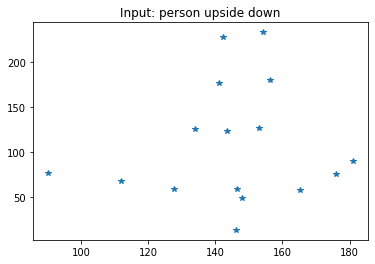

In [5]:
sample_id = 10
sample_2d = gt_2d_train[sample_id,...]
sample_3d = gt_3d_train_rel[sample_id,...]
plt.plot(sample_2d[:,0],sample_2d[:,1],'*')
plt.title('Input: person upside down')

Text(0.5, 1.0, 'Input: Person in 2d image space')

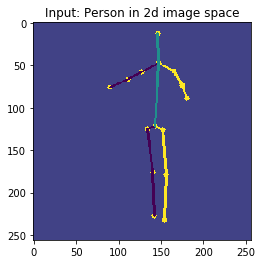

In [6]:
def show2D(points):
    points = ((points.reshape(16, -1))).astype(np.int32)
    img = np.ones((256,256)) * 50
    for j in range(16):
        if j == 7:
            continue
        img = cv2.circle(img, tuple(points[j, :].astype(int)), 3,  (255, 0, 0), cv2.FILLED)
    edges_left = [ [0,1], [1,2],[2,6],[10,11],[12,8],[11,12]]
    edges_middle = [[6, 8],[8, 9]]
    edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5],
         [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15],
         [6, 8], [8, 9]]
    for e in edges:
        if e in edges_left:  ## right and middle: red, left: blue
            cv2.line(img, (points[e[0], 0], points[e[0], 1]),
                  (points[e[1], 0], points[e[1], 1]), [0,0,255], 2)
        elif e in edges_middle:    
            cv2.line(img, (points[e[0], 0], points[e[0], 1]),
                  (points[e[1], 0], points[e[1], 1]), [128,0,128], 2)  
        else:
            cv2.line(img, (points[e[0], 0], points[e[0], 1]),
                  (points[e[1], 0], points[e[1], 1]), [255,0,0], 2) 
    return img
sample_2d_img = show2D(sample_2d)
plt.imshow(sample_2d_img)
plt.title('Input: Person in 2d image space')

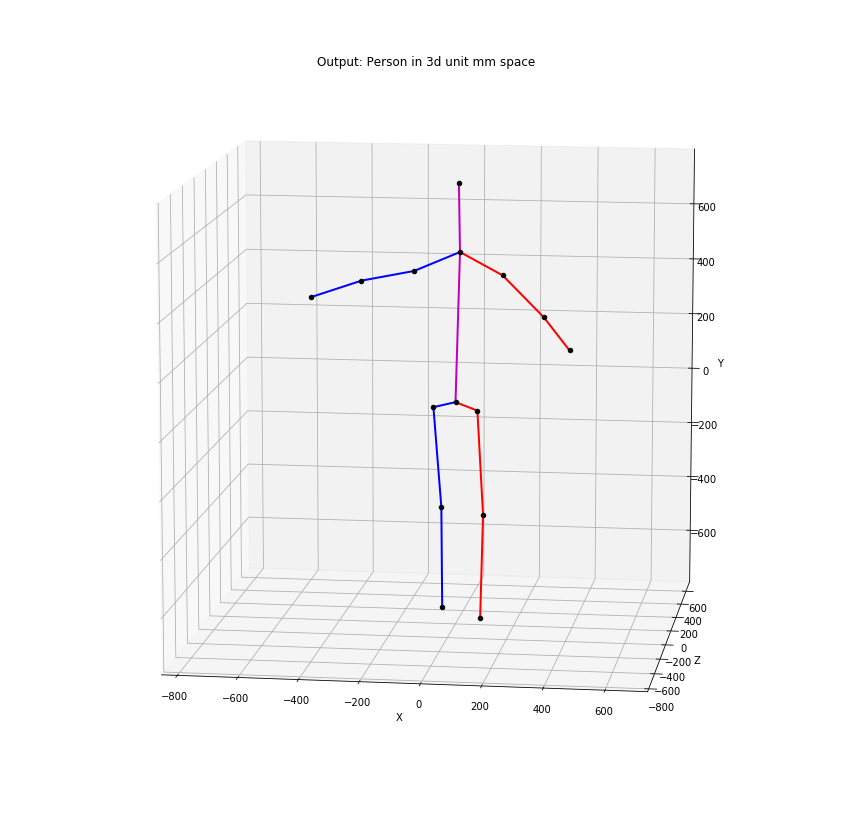

In [7]:
def vis_3d_skeleton(kpt_3d_gt_old): 
    kpt_3d = np.zeros((16,3))
    kpt_3d[:6,:] = kpt_3d_gt_old[:6,:]
    kpt_3d[7:,:] = kpt_3d_gt_old[6:,:]
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    for j in range(16):
        if j == 7:
            continue
        ax.scatter(kpt_3d[j, 0], kpt_3d[j, 2], -kpt_3d[j, 1], c='k', marker='o')
    edges_left = [ [0,1], [1,2],[2,6],[10,11],[12,8],[11,12]]
    edges_middle = [[6, 8],[8, 9]]
    edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5],
             [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15],
             [6, 8], [8, 9]]
    for l in range(len(edges)):
        i1 = edges[l][0]
        i2 = edges[l][1]

        x2 = np.array([kpt_3d[i1, 0], kpt_3d[i2, 0]])
        y2 = np.array([kpt_3d[i1, 1], kpt_3d[i2, 1]])
        z2 = np.array([kpt_3d[i1, 2], kpt_3d[i2, 2]])        
        if edges[l] in edges_left:
            ax.plot(x2, z2, -y2, c='b', linewidth=2)
        elif edges[l] in edges_middle:    
            ax.plot(x2, z2, -y2, c='m', linewidth=2)
        else:
            ax.plot(x2, z2, -y2, c='r', linewidth=2)

    all_joints = kpt_3d
    all_joints[:, 1] *= -1
    bb_min = all_joints.min(axis=0)
    bb_max = all_joints.max(axis=0)
    bb_center = (bb_max + bb_min) * 0.5
    max_dist = np.abs(bb_max - bb_min).max() / 2
    bb_min, bb_max = bb_center - max_dist, bb_center + max_dist
    ax.set_xlim([bb_min[0], bb_max[0]])
    ax.set_ylim([bb_min[2], bb_max[2]])
    ax.set_zlim([bb_min[1], bb_max[1]])

    # Z and Y are swapped
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

    ax.view_init(elev=11, azim=-82)
    plt.title('Output: Person in 3d unit mm space')
vis_3d_skeleton(sample_3d)

In [8]:
#### logistc regression, use samples to train and test
### I encourage you to try random forest as several paper in 3d human pose esitmation shows random forest gives good results
### but you have to think ways to incorporate geometry information [extra faetures]
X = np.reshape(gt_2d_train,(gt_2d_train.shape[0],16*2))
Y = np.reshape(gt_3d_train_rel,(gt_3d_train_rel.shape[0],15*3))
X_val = np.reshape(gt_2d_val,(gt_2d_val.shape[0],16*2))
Y_val = np.reshape(gt_3d_val_rel,(gt_3d_val_rel.shape[0],15*3))
print(X.shape)
print(Y.shape)
print(X_val.shape)
print(Y_val.shape)

(222514, 32)
(222514, 45)
(8000, 32)
(8000, 45)


In [9]:
## basic linear model, besides, you can use more fancy regression model
## in addition, you can concatenate 2d joint with feature to replace X, 
## For example
## X_enc2 = np.reshape(J_train_gt_mdp_enc2_15, (J_train_gt_mdp_enc2_15.shape[0],-1))
## X_mdp15_J = np.reshape(J_train_gt_mdp_15, (J_train_gt_mdp_15.shape[0],-1))
## X_mdp15 = np.reshape(train_gt_mdp_15, (train_gt_mdp_15.shape[0],-1))
## X_new = np.concatenate(X, X_enc2, X_mdp15_J, X_mdp15)
## same operation for validation and testset.
regr = linear_model.LinearRegression()
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
Y_val_pred = regr.predict(X_val)
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print(Y_val_pred_reshape.shape)
### error in 3D Euclidean Space between joint prediction and joint ground truth
def MPJPE_error(gt, pred): ## both prediction and ground truth in N*15*3, I will use this function to calculate final error and rank
    error =  (gt-pred) **2
    pjpe = np.sum(error,2) ** (1/2)
    mpjpe = np.mean(pjpe)
    return mpjpe
print(MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

(8000, 15, 3)
105.86138034883163


In [11]:
### final submission
X_test = np.reshape(gt_2d_test,(gt_2d_test.shape[0],16*2))
Y_test_pred = regr.predict(X_test)
Y_test_pred_reshape = np.reshape(Y_test_pred,(Y_test_pred.shape[0],15,3))
#np.save('Hackthon_groupXXX_submission.npy',Y_test_pred_reshape)